# Computing eigenvalues

From Abel's theorem it follows that we cannot generally compute eigenvalues in closed from for matrices with dimension larger than 4. Hence, we need iterative methods to compute eigenvalues. The most fundamental method to compute eigenvalues is the power method.

## The power method

Let $A\in\mathbb{C}^{n\times n}$ be a given diagonalizable matrix and let $q^{(0)}$ be a starting vector with $\|q^{(0)}\|_2=1$ 

**Algorithm: Power Method**
    
for $k=1,2,\dots$

$\quad z^{(k)} = Aq^{(k-1)}$

$\quad q^{(k)} = z^{(k)}/\|z^{(k)}\|_2$

$\quad \lambda^{(k)} = \left[q^{(k)}\right]^HAq^{(k)}$

end

The analysis of the algorithm is very simple. The normalisation step is only done for numerical purposes to keep the numbers bounded and avoid overflow. The important step is successive multiplication with a vector. Let $A$ be diagonalizable and denote the eigenpairs by $(\lambda_j, x_j)$. We expand the starting vector $q^{(0)}$ in the basis of eigenvectors as $q^{(0)} = \sum_{j}\alpha_jx_j$ for some coefficients $\alpha_j$. We obtain

$$
A^{k}q^{(0)} = \sum_{j=1}^n\alpha_j\lambda_j^kx_j = \alpha_1\lambda_1^{k}\left(x_1+\sum_{j=2}^n\frac{\alpha_j}{\alpha_1}\left(\frac{\lambda_j}{\lambda_1}\right)^kx_j\right).
$$

It follows that the power method converges if $|\lambda_1| > |\lambda_2|$. The error is of the order 
$\mathcal{O}\left(\left|\frac{\lambda_2}{\lambda_1}\right|^k\right)$.

The following code implements the power method.

Text(0, 0.5, '\\lambda_j-\\lambda_1')

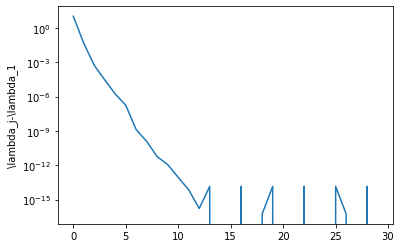

In [3]:
%matplotlib inline


import numpy as np
from numpy.random import rand,randn
from matplotlib import pyplot as plt
from scipy.linalg import eigvals,qr
def power_method(A,q0,k):
    """Evaluates k steps of the power iteration with starting vector q0 for the matrix A. Returns a vector with eigenvalue
       iterates \lambda_j.
    """
    
    lambda_iterates = np.zeros(k,dtype=np.complex128)
    
    q = q0
    
    for i in range(k):
        z = np.dot(A,q)
        q = z/np.linalg.norm(z)
        lambda_iterates[i] = np.dot(np.conjugate(q),np.dot(A,q))
        
    return lambda_iterates

n = 100
k = 30
A = rand(n,n)
q0 = randn(n) + 1j * randn(n)

lambda_iterates = power_method(A,q0,k)
plt.semilogy(np.abs(lambda_iterates-lambda_iterates[-1]))
plt.ylabel('\lambda_j-\lambda_1')

The convergence is very fast. We have the first eigenvalue to machine precision in just over 10 iterations. Why the fast convergence? Let's plot the eigenvalues of the matrix.

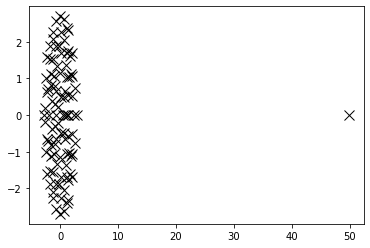

In [4]:
import scipy.linalg

eigvals = scipy.linalg.eigvals(A)
plt.plot(np.real(eigvals), np.imag(eigvals), 'kx',markersize=10)

We see that the largest eigenvalue is at around 50 and far away from the other eigenvalues who cluster around the origin. This is typical for random matrices with equally distributed random numbers in $[0, 1]$. Replace every entry of the matrix by its mean $0.5$, and you get one eigenvalue which is exactly $50$ (the corresponding eigenvector is $x=[1, \dots, 1]^T$). Random matrices may have some very non-random behaviour!

If we replace $A$ by normally  distributed random numbers all eigenvalue are clustered around $0$ and the power method won't converge (Try this out!). A solution here is the inverse iteration.

## Inverse Iteration

The principle idea of inverse iteration is to transform the spectrum of the matrix $A$ in order to accelerate the eigenvalue convergence.

Let $Ax=\lambda x$. Then we have $(A-\sigma I)^{-1}x=(\lambda-\sigma)^{-1}x$. The biggest eigenvalue is now the one that is closest to $\sigma$, and we can expect that the power method will convergence fast to the eigenvalue close to $\sigma$.

Text(0, 0.5, '\\lambda_j-\\lambda_1')

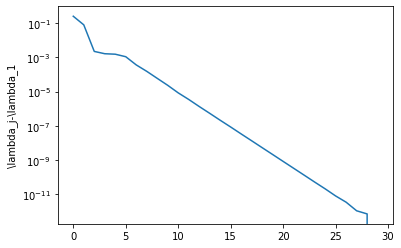

In [6]:
%matplotlib inline

import numpy as np
from numpy.random import rand,randn
from matplotlib import pyplot as plt
from scipy.linalg import eigvals, lu, solve_triangular
def power_method(A,q0,k,sigma):
    """Evaluates k steps of the inverse iteration with starting vector q0 
       for the matrix A and shift sigma. Returns a vector with eigenvalue
       iterates \lambda_j.
    """
    
    lambda_iterates = np.zeros(k,dtype=np.complex128)
    
    q = q0 / np.linalg.norm(q0)
    
    n = A.shape[0]
    
    P,L,U = lu(A-sigma*np.eye(n,n,dtype=A.dtype))
    
    def applyMat(x):
        return solve_triangular(U,solve_triangular(L,np.dot(P,q),lower=True))
    
    for i in range(k):
        z = applyMat(q)
        q = z/np.linalg.norm(z)
        lambda_iterates[i] = np.dot(q.conj(),applyMat(q))
        
    return lambda_iterates

n = 50
k = 30
sigma = .1
A = randn(n,n)
q0 = randn(n) + 1j * randn(n)

lambda_iterates = power_method(A,q0,k,sigma)
plt.semilogy(np.abs(lambda_iterates-lambda_iterates[-1]))
plt.ylabel('\lambda_j-\lambda_1')

## Subspace iteration

So far we are always only targeting one eigenvalue.This can be overcome by the subspace iteration, which computes a partial Schur decomposition and is a generalization of the inverse iteration.

Here, $Q^{(0)}\in\mathbb{C}^{n\times m}$ is a matrix with $m$ columns, satisfying $\left[Q^{(0)}\right]^H Q^{(0)} = I$. The following algorithm converges to an upper triangular $k\times k$ matrix.

***Algorithm (Subspace Iteration)***

for $k=1,2,\dots$

$\quad Z^{(k)} = AQ^{(k-1)}$

$\quad Q^{(k)}R = Z^{(k)}$ (QR decomposition)

$\quad A^{(k)} = [Q^{(k)}]^HAQ^{(k)}$

end



Text(0, 0.5, 'error')

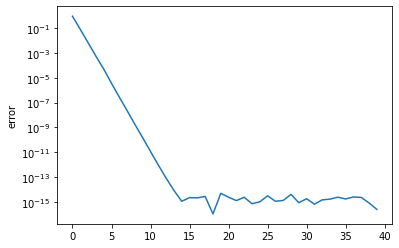

In [8]:
%matplotlib inline
import numpy as np
from numpy.random import rand, randn
from matplotlib import pyplot as plt
from scipy.linalg import qr
def subspace_iteration(A,k,m):
    """Evaluates k steps of the subspace iteration for the matrix A to find the largest m eigenvalues.
       Return a vector of errors computed via the Frobenius norm.
    """
        
    Z0 = np.random.rand(A.shape[0],m)+1j*np.random.rand(A.shape[0],m)
    Q,R = qr(Z0,mode='economic')
    
    error = np.zeros(k,dtype=np.float64)
    
    for i in range(k):
        Z = np.dot(A,Q)
        Q,R = qr(Z,mode='economic')
        Lambda = np.dot(np.conjugate(Q).T,np.dot(A,Q))
        error[i] = np.linalg.norm(np.tril(Lambda,-1))
        
    return error

n = 50
k = 40
m = 2
A = rand(n,n)

error = subspace_iteration(A,k,m)
plt.semilogy(error)
plt.ylabel('error')


The above plot shows the size of the strictly lower triangular part of $A^{(k)}$. As it converges to zero, the elements on the diagonal converge to eigenvalues of $A$.

## Rayleigh quotient iteration

For symmetric eigenvalue problems one can combine the inverse iteration with evaluating the Rayleigh quotient. The idea is that instead of the fixed value $\sigma$ in each step we use as shift the value of the Rayleigh quotient. The resulting algorithm is called Rayleigh quotient iteration. Its convergence is even cubic.

**Algorithm (Rayleigh Quotient Iteration)**

$\lambda^{(0)} = [q^{(0)}]^TAq^{(0)}$

for $k=1,2,\dots$

$\quad z^{(k)} = (A-\lambda^{(k-1)}I)^{-1}q^{(k-1)}$

$\quad q^{(k)} = z^{(k)}/\|z^{(k)}\|_2$

$\quad \lambda^{(k)} = \left[q^{(k)}\right]^TAq^{(k)}$

end

Text(0, 0.5, '\\lambda_j-\\lambda')

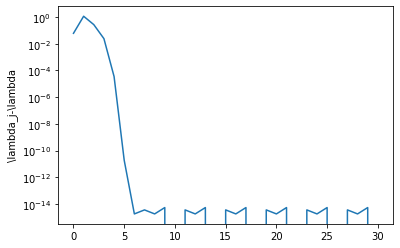

In [11]:
%matplotlib inline

import numpy as np
from numpy.random import rand,randn
from matplotlib import pyplot as plt
from scipy.linalg import eigvals,lu,solve_triangular
def rayleigh_quotient_iteration(A,q0,k,sigma):
    """Evaluates k steps of the Rayleigh quotient iteration. Returns a vector with eigenvalue
       iterates \lambda_j. sigma is an initial shift.
    """
    
    lambda_iterates = np.zeros(k+1,dtype=np.float64)
    
    P,L,U = lu(A-sigma*np.eye(n,n,dtype=A.dtype))
    
    q = solve_triangular(U,solve_triangular(L,np.dot(P,q0),lower=True))
    
    q = q/np.linalg.norm(q0)
    
    lambda_iterates[0] = np.dot(q,np.dot(A,q))
    
    for i in range(1,k+1):
        
        P,L,U = lu(A-lambda_iterates[i-1]*np.eye(n,n,dtype=A.dtype))
        z = solve_triangular(U,solve_triangular(L,np.dot(P,q),lower=True))
        q = z/np.linalg.norm(z)
        lambda_iterates[i] = np.dot(q,np.dot(A,q))
        
    return lambda_iterates

n = 100
k = 30
A = randn(n,n)
A = .5*(A+A.T)
q0 = rand(n)

lambda_iterates = rayleigh_quotient_iteration(A,q0,k,5)
plt.semilogy(np.abs(lambda_iterates-lambda_iterates[-1]))
plt.ylabel('\lambda_j-\lambda')

## The QR iteration

The QR iteration for eigenvalue computations derives from subspace iteratorion and is the work-horse of modern eigenvalue solvers for dense matrices. 

### Convergence of the subspace iteration

Before we can understand the QR iteration let us check on the subspace iteration again.

Let $S\subset\mathbb{C}^n$ be a subspace of dimension $k$. Then the subspace iteration produces subspaces

$$
S_m = A^{m}S.
$$

Denote by $Q^{(0)} = \begin{bmatrix}q_0^{(0)} & q_1^{(0)} & \dots & q_k^{(0)}\end{bmatrix}$ a unitary basis of $S$, and let $Q^{(m)}R^{(m)}$ be the QR decomposition of $A^mQ^{(0)}$. To test convergence we compute

$$
\left[Q^{(m)}\right]^HAQ^{(m)} = \begin{bmatrix}B_{11} & B_{12}\\
                                   B_{21} & B_{22}
                     \end{bmatrix}
$$

for some matrices $B_{ij}$, $i, j=1,2$.

The subspace iteration converges to an invariant subspace also for each $j\leq k$. Hence, we have a sequence of approximate invariant subspaces for $j\leq k$ that all converge to invariant subspaces. It follows that

$$
\left[Q^{(m)}\right]^HAQ^{(m)}\rightarrow R
$$

with $R$ upper triangular. The upper triangularity of $R$ follows from the property of nested invariant subspaces that we are converging to.

We can now ask the question what happens if we increase the basis vectors $k$. We always converge to an upper triangular matrix. In particular, there is no reason not to choose $k=n$, that is to iterate on the whole vector space. We call this simultaneous iteration and it follows that also in this case we converge to an upper triangular matrix.


### The QR iteration

Let $A^{(1)} = A$. The basic form of the algorithm is exceedingly simple. Let $A^{(m)}$ be our current iterate. Compute the QR decomposition $A^{(m)} = Q_mR_m$ and let $A^{(m+1)} = R_mQ_m$ (note that we use subscripts to distinguish from the QR factors in the simultaneous iteration, which have superscripts). That's it. In each step we just compute a QR decomposition and multiply the factors in reverse order again. Why does this work? The magic lies in understanding the connection with subspace iteration.

In the QR iteration we have

$$
A^{(m+1)} = Q_m^HA^{(m)}Q_m.
$$

This looks just like the testing from the simultaneous iteration, and with a little bit of algebra one can show that simultaneous iteration with $Q^{(0)} = I$ produces the same sequence $A^{(m)}$.

Let's demonstrate this. The QR iteration gives us

$$
A = Q_1R_1.
$$

We hence have

$$
\begin{aligned}
A^2 &= Q_1R_1Q_1R_1\\
    &= Q_1A^{(2)}R_1\\
    &= Q_1Q_2R_2R_1.
\end{aligned}
$$

In the next step we have

$$
\begin{aligned}
A^3 &= Q_1R_1Q_1R_1Q_1R_1\\
    &= Q_1Q_2R_2Q_2R_2R_1\\
    &= Q_1Q_2Q_3R_3R_2R_1.
\end{aligned}
$$

Every time we have used that $Q_kR_k = R_{k-1}Q_{k-1}$.

Continuing this it is easy to see that

$$
A^m = Q_1\dots Q_mR_m \dots R_1 = Q^{(m)}R^{(m)},
$$

where the $Q^{(m)}$ and $R^{(m)}$ are the QR factors from applying $m$ steps of simultaneous iteration with $Q^{(0)}=I$ as start basis.

Let us now do the testing step of the simultaneous iteration. We have

$$
\begin{aligned}
\left[Q^{(m)}\right]^HAQ^{(m)} &= Q_m^H\dots Q_1^HAQ_1\dots Q_m\\
                               &= Q_m^H\dots Q_2^H A^{(2)}Q_2\dots Q_m\\
                               &= Q_m^H\dots Q_3^HA^{(3)}Q_3\dots Q_m\\
                               &= \dots\\
                               &= A^{(m+1)}
\end{aligned}.
$$

Hence, the iterates $A^{(m)}$ from the QR iteration and the testing procedure $\left[Q^{(m)}\right]^HAQ^{(m)}$ from the simultaneous iteration are related by

$$
A^{(m+1)} = \left[Q^{(m)}\right]^HAQ^{(m)}.
$$

We know that the products $\left[Q^{(m)}\right]^HAQ^{(m)}$ converge to an upper triangular matrix by virtue of convergence of nested invariant subspaces. It follows therefore that also the QR iteration converges to an upper triangular matrix, from which we can read off the eigenvalues of $A$.

### Accelerating the QR iteration in practice

The basic form of the QR iteration has some problems.

- Computing the QR decomposition in each step is rather expensive.
- Convergence can be extremely slow.
- It is not suitable for finding complex eigenvalues of real matrices. We cannot converge in real arithmetic to an upper triangular matrix with complex entries.


All three problems can be overcome.

- To make a QR iteration step cheaper we preprocess the matrix $A$ by an orthogonal transformation to so-called upper Hessenberg form. This is matrix whose upper triangular and first lower diagonal are nonzero. This transformation can easily be achieved in $O(n^3)$ operations in a finite number of steps (i.e. it is not an iterative process). A QR iteration step preserves the uppper Hessenberg form and can be very cheaply implemented.

- To speed-up convergence we can use a shifting strategy that can be shown to be equivalent to inverse iteration.

- To find complex eigenvalues one uses a double-shift strategy that ends up not with an upper triangular matrix $R$ but with a block upper triangular matrix, where the complex eigenvalues are computed from 2x2 real blocks on the diagonal.

In the following computational section we demonstrate the upper Hessenberg form and shift strategies. We will not go into details about double shifts for complex eigenvalues.

### Numerical investigation of QR iteration steps

In [3]:
import numpy as np
from scipy.linalg import qr, hessenberg
from matplotlib import pyplot as plt
%matplotlib inline

We start with some random matrix $A$.

In [4]:
rand = np.random.RandomState(0)
n = 10
A  = rand.randn(n, n) + 1j * rand.randn(n, n)

Let us first tranform the matrix to upper Hessenberg form. This can be implemented as similarity transformation that does not change the eigenvalues.

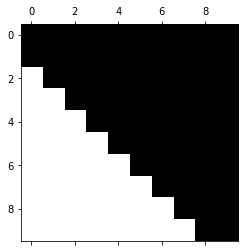

In [5]:
H = hessenberg(A)
plt.spy(H)

We see that the matrix and its first lower diagonal are nonzero. Upper Hessenberg structures are preserved by a QR iteration step. Let's check this.

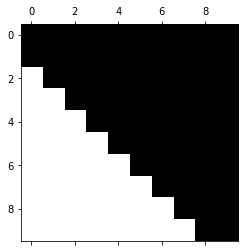

In [6]:
Q, R = qr(H)
H2 = R @ Q
plt.spy(H2)

This structure preservation can be used to implement a QR iteration step in a highly efficient manner. We will not go into technical details about this here.

Let us now run a couple of iterations of the QR iteration and let's see how quickly the second to last element in the last row of $H$ converges to zero. If it is zero the bottom last diagonal element is a wanted eigenvalue (convince yourself that this is true).

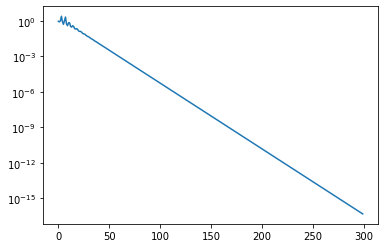

In [9]:
nsteps = 300

H = hessenberg(A)

residuals = np.empty(nsteps, dtype='float64')

for index in range(nsteps):
    Q, R = qr(H)
    H = R @ Q
    residuals[index] = np.abs(H[-1, -2]) / np.abs(H[-1, -1])
    
plt.semilogy(residuals)

The convergence is extremely slow. We can speed this up by a shift strategy. The idea is to modify the QR iteration step so that it reads

$$
\begin{aligned}
A^{(m)} -\alpha I &= Q_mR_m\\
A^{(m+1)} &= R_mQ_m + \alpha I.
\end{aligned}
$$

Hence, we subtract the shift and do the QR decomposition, and then when we compute $R_mQ_m$ we add the shift back in.

Once can show that a QR step is equivalent to inverse iteration applied to the last vector in the simultaneous iteration. Hence, by applying the shift we perform a shifted inverse iteration. What shall we use as shift?

It turns out that we achieve quadratic convergence if we simply use the bottom right element of the Hessenberg matrix in each step as shift. This is similar to the Rayleigh quotient method for symmetric problems, where we adapted the shift in each step.

The following implements the shift strategy.

Residual: 0.508873616732413
Residual: 0.2076653000186893
Residual: 0.18529890729552823
Residual: 0.01935687814656868
Residual: 0.00034094139006009337
Residual: 1.1837354557680947e-07
Residual: 1.3539693075470919e-14


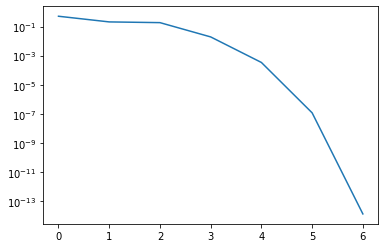

In [13]:
nsteps = 7

H = hessenberg(A)

residuals = np.empty(nsteps, dtype='float64')

ident = np.eye(n)

for index in range(nsteps):
    shift = H[-1, -1]
    Q, R = qr(H - shift * ident)
    H = np.dot(R, Q) + shift * ident
    residual = np.abs(H[-1, -2]) / np.abs(H[-1, -1])
    print(f"Residual: {residual}")
    residuals[index] = residual
    
plt.semilogy(residuals)

We have converged in 7 iterations. Let us now reduce the matrix and continue with the next smaller matrix.

Residual: 1.0943921434074488e-05
Residual: 7.568006610141011e-11
Residual: 3.1024322351139375e-21


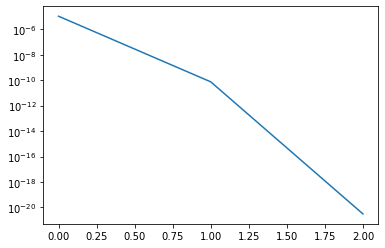

In [15]:
nsteps = 3

H_reduced = H[:-1, :-1] # Copy H over to preserve the original matrix

residuals = np.empty(nsteps, dtype='float64')

ident = np.eye(n-1, n-1)

for index in range(nsteps):
    shift = H_reduced[-1, -1]
    Q, R = qr(H_reduced - shift * ident)
    H_reduced = R @ Q + shift * ident
    residual = abs(H_reduced[-1, -2]) / abs(H_reduced[-1, -1])
    print(f"Residual: {residual}")
    residuals[index] = residual
    
plt.semilogy(residuals)

We have now converged in 3 iterations. In practice, with more sophisticated shift variants and good deflation strategies the QR iteration takes typically only 2 to 3 iterations per eigenvalue, where each iteration has quadratic cost. Hence, the overall algorithm converges usually in cubic time. Therefore, even though the QR iteration is an iterative algorithm we therefore speak of a method with cubic complexitiy since this holds in almost all cases.